In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from random import sample
import scipy.misc
import matplotlib.cm as cm
from scipy import linalg

In [2]:
#finding closest centroids
datafile='ex7data2.mat'
mat=scipy.io.loadmat(datafile)
X=mat['X']

In [3]:
#chooser the number of centroids
K=3
#초깃값은 수동으로 지정함. 
initial_centroids=np.array([[3,3],[6,2],[8,5]])

In [23]:
#주어진 데이터를 시각화로 확인한다. 
def plotData(myX,mycentroids,myidxs = None):
    colors = ['b','g','gold','darkorange','salmon','olivedrab']
    
    assert myX[0].shape == mycentroids[0][0].shape
    assert mycentroids[-1].shape[0] <= len(colors)

    #If idxs is supplied, divide up X into colors
    if myidxs is not None:
        assert myidxs.shape[0] == myX.shape[0]
        subX = []
        for x in range(mycentroids[0].shape[0]):
            subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i] == x]))
    else:
        subX = [myX]
        
    fig = plt.figure(figsize=(7,5))
    for x in range(len(subX)):
        newX = subX[x]
        plt.plot(newX[:,0],newX[:,1],'o',color=colors[x],
                 alpha=0.75, label='Data Points: Cluster %d'%x)
    plt.xlabel('x1',fontsize=14)
    plt.ylabel('x2',fontsize=14)
    plt.title('Plot of X Points',fontsize=16)
    plt.grid(True)

    #Drawing a history of centroid movement
    tempx, tempy = [], []
    for mycentroid in mycentroids:
        tempx.append(mycentroid[:,0])
        tempy.append(mycentroid[:,1])
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'rx--', markersize=8)

    leg = plt.legend(loc=4, framealpha=0.5)

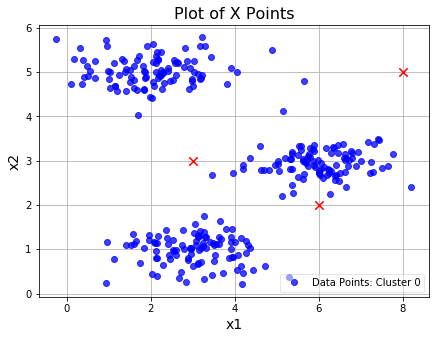

In [24]:
plotData(X,[initial_centroids])

In [25]:
#거리의 제곱을 구하는 공식을 함수화 
def distSquared(point1, point2):
    assert point1.shape==point2.shape #자료형 통일 
    return np.sum(np.square(point2-point1)) #계산

In [26]:
#각데이터에서 가장 가까운 centroid점을 찾는 경우 
def findClosestCentroids(myX, mycentroids):
    idxs = np.zeros((myX.shape[0],1))
    
    #Loop through each data point in X
    for x in range(idxs.shape[0]):
        mypoint = myX[x]
        #Compare this point to each centroid,
        #Keep track of shortest distance and index of shortest distance
        mindist, idx = 9999999, 0
        for i in range(mycentroids.shape[0]):
            mycentroid = mycentroids[i]
            distsquared = distSquared(mycentroid,mypoint)
            if distsquared < mindist:
                mindist = distsquared
                idx = i
        #With the best index found, modify the result idx vector
        idxs[x] = idx
        
    return idxs

In [27]:
X[:3] #(x,y)형태로 되어있는 데이터 형식 3개만 확인 

array([[1.84207953, 4.6075716 ],
       [5.65858312, 4.79996405],
       [6.35257892, 3.2908545 ]])

In [28]:
idxs = findClosestCentroids(X,initial_centroids)

#you should see the output [1 3 2] corresponding to the 
#centroid assignments for the first 3 examples.
#Note my indices start at 0, so I should see [0, 2, 1]
print(idxs[:3].flatten())

[0. 2. 1.]


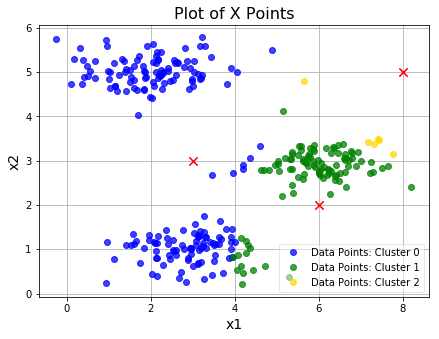

In [29]:
plotData(X,[initial_centroids],idxs)

In [50]:
#centoid means를 다시 계산하는 경우 
def computeCentroids(myX, myidx):
    subX = []
    for x in range(len(np.unique(myidx))):
        subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidx[i] == x]))
    return np.array([np.mean(thisX,axis=0) for thisX in subX])

In [51]:
#kmeans on example dataset
def runKMeans(myX, initial_centroids, K, n_iter):
    centroid_history = []
    current_centroids = initial_centroids
    for myiter in range(n_iter):
        centroid_history.append(current_centroids)
        idxs = findClosestCentroids(myX,current_centroids)
        current_centroids = computeCentroids(myX,idxs)
        
    return idxs, centroid_history

In [52]:
idxs, centroid_history = runKMeans(X,initial_centroids,K=3,n_iter=10)

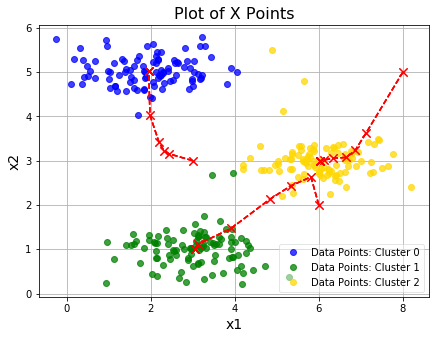

In [53]:
plotData(X,centroid_history,idxs)

In [54]:
#random initializer
#인덱스 값을 랜덤으로 지정해준다, 
def chooseKRandomCentroids(myX, K):
    rand_indices=sample(range(0, myX.shape[0]),K)
    return np.array([myX[i] for i in rand_indices])

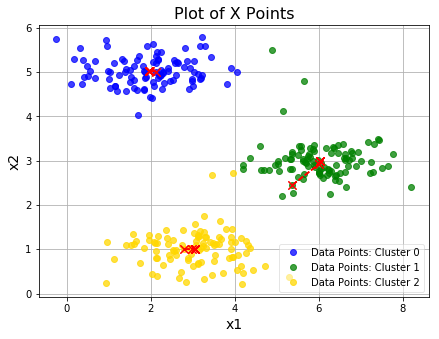

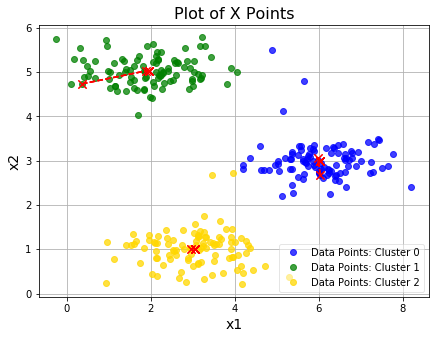

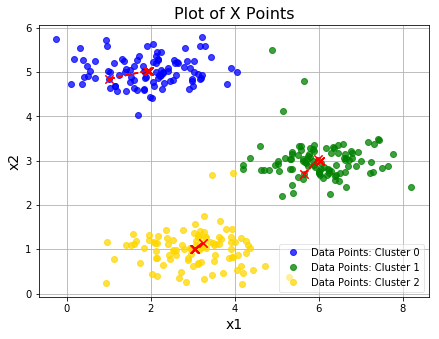

In [55]:
#랜덤 초기화 이후에 Kmeans돌리는 경우 
for x in range(3):
    idxs, centroid_history=runKMeans(X, chooseKRandomCentroids(X,K=3), K=3, n_iter=10)
    plotData(X, centroid_history, idxs)

**Kmeans를 이용한 이미지의 분할과 압축** <br>
- 목표 : 이미지 영역의 동질의 시각적 영역 단위로 나누는 작업
- 각 이미지의 픽셀을 하나의 데이터포인트로 간주한다. 
- 각 색상의 범위(R,G,B)를 정규화 하여 0~1사이의 값만 가지게 한다. 
- 벡터 양자화 : N개의 픽셀이 주어졌을 때 이를 K개의 클러스터에 각각 할당한 후, 각 cluster에 대해 중심값을 저장한다. 
- 참고 blog : http://norman3.github.io/prml/docs/chapter09/1.html

A.shape is (128, 128, 3)


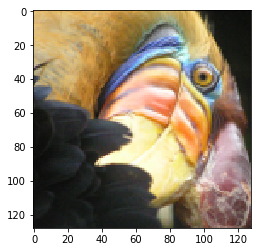

In [58]:
#이미지 데이터 압축하는 예제
import warnings
warnings.filterwarnings('ignore')
datafile='bird_small.png'
A=scipy.misc.imread(datafile) #이미지를 읽어 데이터형식 저장 
print("A.shape is", A.shape)
dummy=plt.imshow(A)

In [60]:
A[:3] #픽셀값으로 데이터를 저장하는 경우 

array([[[219, 180, 103],
        [230, 185, 116],
        [226, 186, 110],
        ...,
        [ 14,  15,  13],
        [ 13,  15,  12],
        [ 12,  14,  12]],

       [[230, 193, 119],
        [224, 192, 120],
        [226, 192, 124],
        ...,
        [ 16,  16,  13],
        [ 14,  15,  10],
        [ 11,  14,   9]],

       [[228, 191, 123],
        [228, 191, 121],
        [220, 185, 118],
        ...,
        [ 14,  16,  13],
        [ 13,  13,  11],
        [ 11,  15,  10]]], dtype=uint8)

In [61]:
#각 색상을 0~1사이의 값을 가지도록 한다. 
A=A/255
#크기 변형
A=A.reshape(-1, 3)
#kmeans 적용
myK=16
idxs, centroid_history=runKMeans(A,chooseKRandomCentroids(A,myK),
                                   myK,n_iter=10)

In [62]:
#각 cluster에 속하는 값들에는 동일한 색을 주는 경우 
idxs=findClosestCentroids(A, centroid_history[-1])

In [64]:
final_centroids = centroid_history[-1]
# Now loop through the original image and form a new image
# that only has 16 colors in it
final_image = np.zeros((idxs.shape[0],3))
for x in range(final_image.shape[0]):
    final_image[x] = final_centroids[int(idxs[x])]

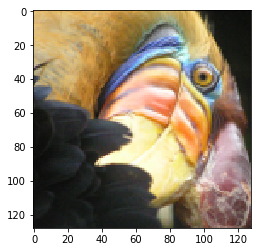

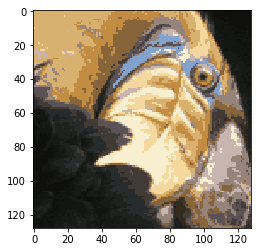

In [66]:
# Reshape the original image and the new, final image and draw them
# To see what the "compressed" image looks like
plt.figure()
dummy = plt.imshow(A.reshape(128,128,3))
plt.figure()
dummy = plt.imshow(final_image.reshape(128,128,3))

**PCA example**

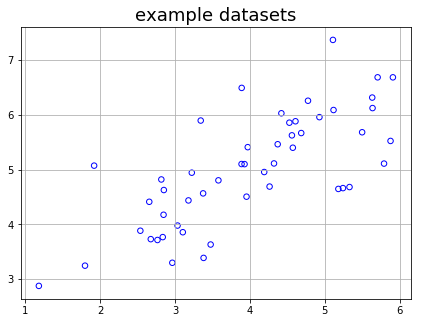

In [67]:
datafile='ex7data1.mat'
mat=scipy.io.loadmat(datafile)
X=mat['X']

#plotting
plt.figure(figsize=(7,5))
plot=plt.scatter(X[:,0], X[:,1], s=30, facecolors='none', edgecolors='b')
plt.title('example datasets', fontsize=18)
plt.grid(True)

In [69]:
#위의 형태의 데이터에 PCA적용
#PCA전처리 과정으로 반드시 정규화 필요하다. 
def featureNormalize(myX):
    means=np.mean(myX, axis=0)
    myX_norm=myX-means
    stds=np.std(myX_norm,axis=0)
    myX_norm=myX_norm/stds
    return means, stds, myX_norm

In [72]:
#고유벡터에 투영할 때 분산이 최대가 되므로 SVD를 활용한다
def getUSV(myX_norm):
    cov_matrix=myX_norm.T.dot(myX_norm)/myX_norm.shape[0]
    U,S,V=scipy.linalg.svd(cov_matrix, full_matrices=True, compute_uv=True)
    return U,S,V

In [73]:
#바로 위에서 적용한 함수의 적용, 확인
means, stds, X_norm=featureNormalize(X)
U, S, V = getUSV(X_norm)

In [76]:
#projecting the data onto the principal components
#SVD의 결과에서 U값에서 해당 k만큼 뽑아 projection하는 것이 best
def projectData(myX, myU, K):
    Ureduced=myU[:,:K]
    z=myX.dot(Ureduced)
    return z

In [ ]:
z = projectData(X_norm,U,1)
print('Projection of the first example is %0.3f.'%float(z[0])